In [122]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM, BatchNormalization,MaxPooling2D,Reshape, GRU
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [123]:
## Loading the numpy arrays corresponding to the EEG dataset



X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


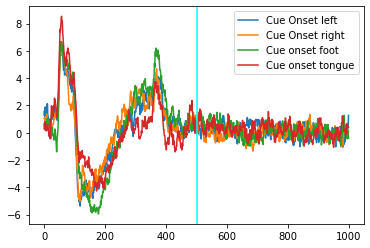

In [124]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769
## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])



In [125]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [126]:
## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (1500, 4)
Shape of test labels after categorical conversion: (1772, 4)
Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after adding width i

In [127]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
#basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
#basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
#basic_cnn_model.add(BatchNormalization())
#basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 84, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_47 (Bat  (None, 84, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_47 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_46 (Conv2D)          (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 28, 1, 50)      

In [128]:
# Model parameters
learning_rate = 1.5e-4
epochs = 200
cnn_optimizer = keras.optimizers.Adam(learning_rate)

In [129]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=200,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)




Epoch 1/200
35/35 [==============================] - 16s 313ms/step - loss: 2.2983 - accuracy: 0.2680 - val_loss: 1.7529 - val_accuracy: 0.3433
Epoch 2/200
35/35 [==============================] - 9s 267ms/step - loss: 2.0249 - accuracy: 0.3188 - val_loss: 1.3817 - val_accuracy: 0.4133
Epoch 3/200
35/35 [==============================] - 9s 264ms/step - loss: 1.9541 - accuracy: 0.3303 - val_loss: 1.2646 - val_accuracy: 0.4427
Epoch 4/200
35/35 [==============================] - 9s 265ms/step - loss: 1.8417 - accuracy: 0.3526 - val_loss: 1.2331 - val_accuracy: 0.4520
Epoch 5/200
35/35 [==============================] - 9s 251ms/step - loss: 1.7573 - accuracy: 0.3777 - val_loss: 1.1955 - val_accuracy: 0.4740
Epoch 6/200
35/35 [==============================] - 11s 314ms/step - loss: 1.7094 - accuracy: 0.3760 - val_loss: 1.1860 - val_accuracy: 0.4733
Epoch 7/200
35/35 [==============================] - 9s 249ms/step - loss: 1.6621 - accuracy: 0.3899 - val_loss: 1.1525 - val_accuracy: 0.49

Epoch 58/200
35/35 [==============================] - 10s 296ms/step - loss: 0.8729 - accuracy: 0.6478 - val_loss: 0.7168 - val_accuracy: 0.7300
Epoch 59/200
35/35 [==============================] - 9s 244ms/step - loss: 0.8486 - accuracy: 0.6628 - val_loss: 0.7216 - val_accuracy: 0.7267
Epoch 60/200
35/35 [==============================] - 9s 258ms/step - loss: 0.8507 - accuracy: 0.6622 - val_loss: 0.7139 - val_accuracy: 0.7340
Epoch 61/200
35/35 [==============================] - 9s 270ms/step - loss: 0.8656 - accuracy: 0.6504 - val_loss: 0.7154 - val_accuracy: 0.7260
Epoch 62/200
35/35 [==============================] - 9s 247ms/step - loss: 0.8461 - accuracy: 0.6602 - val_loss: 0.6964 - val_accuracy: 0.7460
Epoch 63/200
35/35 [==============================] - 9s 255ms/step - loss: 0.8425 - accuracy: 0.6599 - val_loss: 0.7015 - val_accuracy: 0.7387
Epoch 64/200
35/35 [==============================] - 9s 247ms/step - loss: 0.8386 - accuracy: 0.6678 - val_loss: 0.7015 - val_accuracy

Epoch 115/200
35/35 [==============================] - 7s 213ms/step - loss: 0.6377 - accuracy: 0.7501 - val_loss: 0.5036 - val_accuracy: 0.8020
Epoch 116/200
35/35 [==============================] - 7s 187ms/step - loss: 0.6303 - accuracy: 0.7599 - val_loss: 0.5005 - val_accuracy: 0.8020
Epoch 117/200
35/35 [==============================] - 7s 199ms/step - loss: 0.6161 - accuracy: 0.7572 - val_loss: 0.4913 - val_accuracy: 0.8113
Epoch 118/200
35/35 [==============================] - 7s 210ms/step - loss: 0.6121 - accuracy: 0.7585 - val_loss: 0.4958 - val_accuracy: 0.8047
Epoch 119/200
35/35 [==============================] - 8s 217ms/step - loss: 0.6232 - accuracy: 0.7583 - val_loss: 0.5040 - val_accuracy: 0.8060
Epoch 120/200
35/35 [==============================] - 8s 222ms/step - loss: 0.6171 - accuracy: 0.7557 - val_loss: 0.4837 - val_accuracy: 0.8227
Epoch 121/200
35/35 [==============================] - 8s 218ms/step - loss: 0.6016 - accuracy: 0.7687 - val_loss: 0.4869 - val_ac

35/35 [==============================] - 6s 165ms/step - loss: 0.5102 - accuracy: 0.7991 - val_loss: 0.3525 - val_accuracy: 0.8753
Epoch 172/200
35/35 [==============================] - 6s 165ms/step - loss: 0.5082 - accuracy: 0.8023 - val_loss: 0.3486 - val_accuracy: 0.8760
Epoch 173/200
35/35 [==============================] - 6s 163ms/step - loss: 0.5106 - accuracy: 0.8023 - val_loss: 0.3371 - val_accuracy: 0.8813
Epoch 174/200
35/35 [==============================] - 6s 174ms/step - loss: 0.4874 - accuracy: 0.8099 - val_loss: 0.3454 - val_accuracy: 0.8787
Epoch 175/200
35/35 [==============================] - 6s 169ms/step - loss: 0.5144 - accuracy: 0.8001 - val_loss: 0.3369 - val_accuracy: 0.8820
Epoch 176/200
35/35 [==============================] - 6s 186ms/step - loss: 0.4992 - accuracy: 0.8095 - val_loss: 0.3233 - val_accuracy: 0.8907
Epoch 177/200
35/35 [==============================] - 6s 171ms/step - loss: 0.4989 - accuracy: 0.8076 - val_loss: 0.3228 - val_accuracy: 0.8907

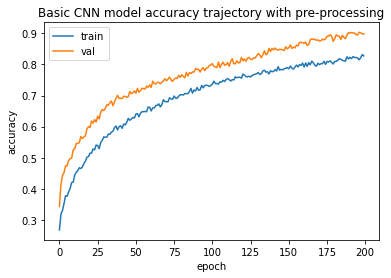

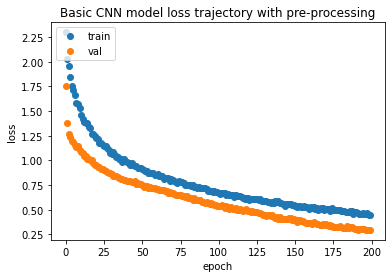

In [139]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory with pre-processing')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory with pre-processing')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [131]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.7240406274795532


In [33]:
## (iii)(CNN-LSTM) Defining the architecture of the hybrid CNN-LSTM model

In [132]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 4
#hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
#hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
#hybrid_cnn_lstm_model.add(BatchNormalization())
#hybrid_cnn_lstm_model.add(Dropout(0.5))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(100, dropout=0.6, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=True))

hybrid_cnn_lstm_model.add(LSTM(70, dropout=0.6, recurrent_dropout=0.1, return_sequences=False))
# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()



Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 250, 1, 100)       22100     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 84, 1, 100)       0         
 g2D)                                                            
                                                                 
 batch_normalization_50 (Bat  (None, 84, 1, 100)       400       
 chNormalization)                                                
                                                                 
 dropout_50 (Dropout)        (None, 84, 1, 100)        0         
                                                                 
 conv2d_49 (Conv2D)          (None, 84, 1, 100)        100100    
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 28, 1, 100)     

In [134]:
# Model parameters
learning_rate = 2e-3
epochs = 50
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)

In [135]:
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=200,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)



Epoch 1/50
35/35 [==============================] - 100s 2s/step - loss: 1.3622 - accuracy: 0.3089 - val_loss: 1.4413 - val_accuracy: 0.3367
Epoch 2/50
35/35 [==============================] - 50s 1s/step - loss: 1.2407 - accuracy: 0.4200 - val_loss: 1.3842 - val_accuracy: 0.3933
Epoch 3/50
35/35 [==============================] - 61s 2s/step - loss: 1.1370 - accuracy: 0.4909 - val_loss: 1.1530 - val_accuracy: 0.5140
Epoch 4/50
35/35 [==============================] - 58s 2s/step - loss: 1.0660 - accuracy: 0.5269 - val_loss: 1.1057 - val_accuracy: 0.5140
Epoch 5/50
35/35 [==============================] - 54s 2s/step - loss: 1.0008 - accuracy: 0.5681 - val_loss: 1.0192 - val_accuracy: 0.5740
Epoch 6/50
35/35 [==============================] - 58s 2s/step - loss: 0.9727 - accuracy: 0.5728 - val_loss: 0.9433 - val_accuracy: 0.5960
Epoch 7/50
35/35 [==============================] - 65s 2s/step - loss: 0.9107 - accuracy: 0.6168 - val_loss: 0.9004 - val_accuracy: 0.6113
Epoch 8/50
35/35 [=

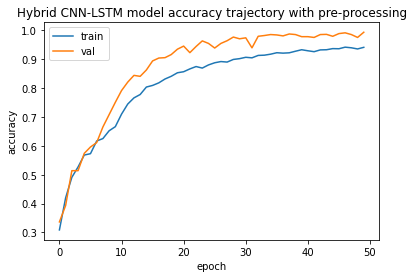

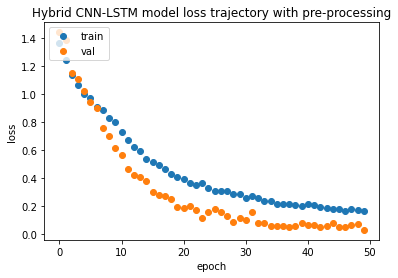

In [138]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory with pre-processing')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory with pre-processing')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [137]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.7082392573356628
